In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [2]:
import os

folder = r'C:\Users\New\Downloads\VS\brazil'

file = {
    'customers': 'olist_customers_dataset.csv',
    'geolocation': 'olist_geolocation_dataset.csv',
    'orders': 'olist_orders_dataset.csv',
    'items': 'olist_order_items_dataset.csv',
    'payments': 'olist_order_payments_dataset.csv',
    'reviews': 'olist_order_reviews_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv',
    'category_translation': 'product_category_name_translation.csv'
}

df = {name: 
      pd.read_csv(os.path.join(folder,fname))
      for name, fname in file.items()}

In [3]:
orders = df['orders'] 
customers = df['customers']
items = df['items']
payments = df['payments']
reviews = df['reviews']
products = df['products']
sellers = df['sellers']
prdt_trans = df['category_translation']
location = df['geolocation']

# Merged Tables

In [4]:
b1 = (
    orders
    .merge(customers, on='customer_id')
    .merge(items, on='order_id')
    .merge(payments, on='order_id')
    .merge(reviews, on='order_id')
)
b2 = (
    items
    .merge(products, on='product_id')
    .merge(prdt_trans, on='product_category_name')
    .merge(sellers, on='seller_id')
    .merge(payments, on='order_id')
)
b3 = (products.merge(prdt_trans, on='product_category_name'))
b4 = (
    reviews
    .merge(items, on='order_id')
    .merge(products, on='product_id')
    .merge(prdt_trans, on='product_category_name')
)

In [ ]:
plt.style.use('seaborn-v0_8-dark-palette')

## Top 10 Products by Revenue

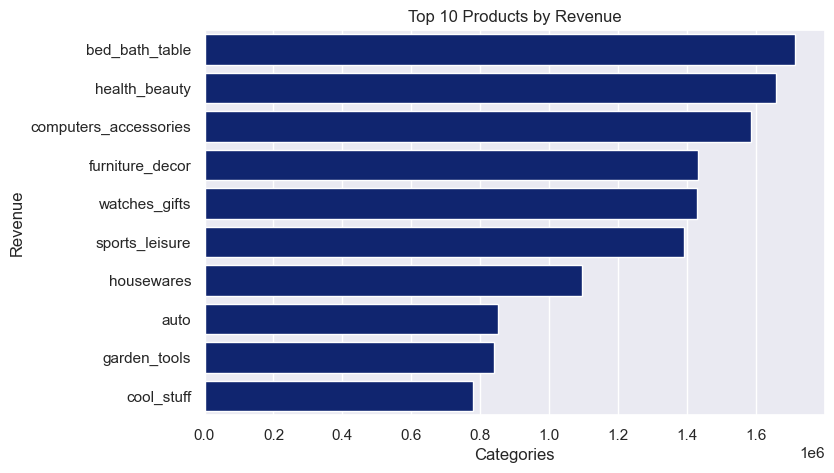

In [49]:
product_revenue = (b2.groupby('product_category_name_english')['payment_value'].sum().reset_index()).sort_values('payment_value', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='payment_value', y='product_category_name_english', data=product_revenue)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Categories')
plt.ylabel('Revenue')
plt.show()

## Top 10 States by Revenue

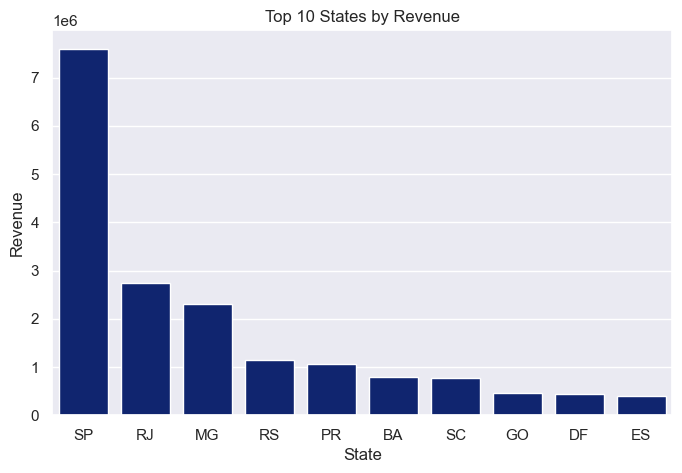

In [13]:
state_revenue = (b1.groupby('customer_state')['payment_value'].sum().reset_index()).sort_values('payment_value', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='customer_state', y='payment_value', data=state_revenue)
plt.title('Top 10 States by Revenue')
plt.xlabel('State')
plt.ylabel('Revenue')
plt.show()

## Count of Order Status

In [14]:
status = b1['order_status'].value_counts().reset_index()
status.columns = ['Order Status', 'Count']
status

,Order Status,Count
0,delivered,114859
1,shipped,1167
2,canceled,553
3,invoiced,370
4,processing,370
5,unavailable,7
6,approved,3


In [16]:
b1['order_purchase_timestamp'] = pd.to_datetime(b1['order_purchase_timestamp'])
b1['order_delivered_customer_date'] = pd.to_datetime(b1['order_delivered_customer_date'])
b1['order_estimated_delivery_date'] = pd.to_datetime(b1['order_estimated_delivery_date'])

# Outlier Detection

### Outlier - Delivery Time

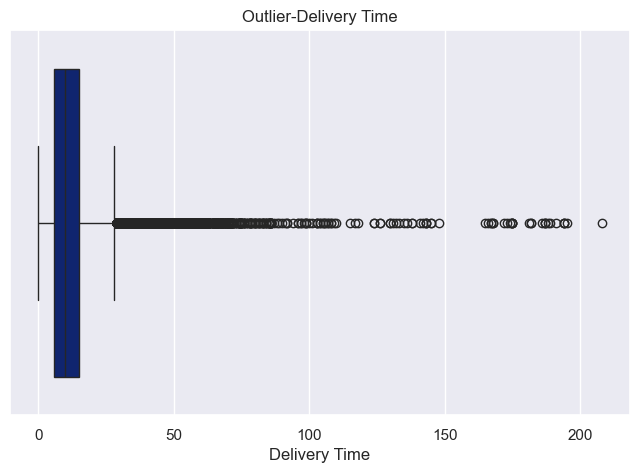

In [18]:
b1['delivery_time'] = (b1['order_delivered_customer_date'] - b1['order_purchase_timestamp']).dt.days

plt.figure(figsize=(8,5))
sns.boxplot(x=b1['delivery_time'])
plt.xlabel('Delivery Time')
plt.title('Outlier-Delivery Time')
plt.show()

### Description of Delivery Time Percentile

In [65]:
delivery_percentiles = b1['delivery_time'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]).round(2)
delivery_percentiles

count    114858.00
mean         11.98
std           9.37
min           0.00
25%           6.00
50%          10.00
75%          15.00
90%          22.00
95%          28.00
max         208.00
Name: delivery_time, dtype: float64

### Outlier - Freight Cost

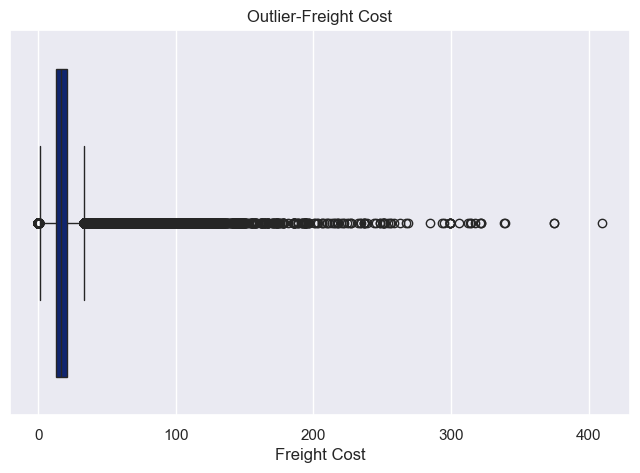

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x=b1['freight_value'])
plt.xlabel('Freight Cost')
plt.title('Outlier-Freight Cost')
plt.show()

### Description of Freight Cost Percentile

In [67]:
freight_value_percentiles = b1['freight_value'].describe(percentiles=[0.25,0.50,0.75,0.90,0.95]).round(2)
freight_value_percentiles

count    117329.00
mean         20.03
std          15.83
min           0.00
25%          13.08
50%          16.28
75%          21.18
90%          34.15
95%          45.29
max         409.68
Name: freight_value, dtype: float64

### Outlier - Payments

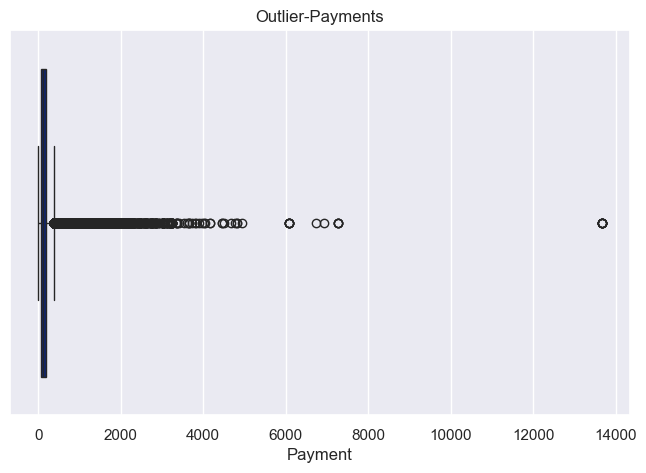

In [27]:
plt.figure(figsize=(8,5))
sns.boxplot(x=b1['payment_value'])
plt.xlabel('Payment')
plt.title('Outlier-Payments')
plt.show()

### Description of Payment Percentile

In [69]:
payment_percentile = b1['payment_value'].describe(percentiles= [0.25, 0.50, 0.75, 0.90, 0.95]).round(2)
payment_percentile

count    117329.00
mean        172.06
std         265.39
min           0.00
25%          60.75
50%         108.10
75%         189.06
90%         337.04
95%         513.31
max       13664.08
Name: payment_value, dtype: float64

## Monthly Revenue Trend

In [25]:
b1['year'] = b1['order_purchase_timestamp'].dt.year
b1['month'] = b1['order_purchase_timestamp'].dt.month

revenue = (b1.groupby(['year','month'])['payment_value'].sum().reset_index())
revenue['year_month'] = (revenue['year'].astype(str) + '-' + revenue['month'].astype(str).str.zfill(2))

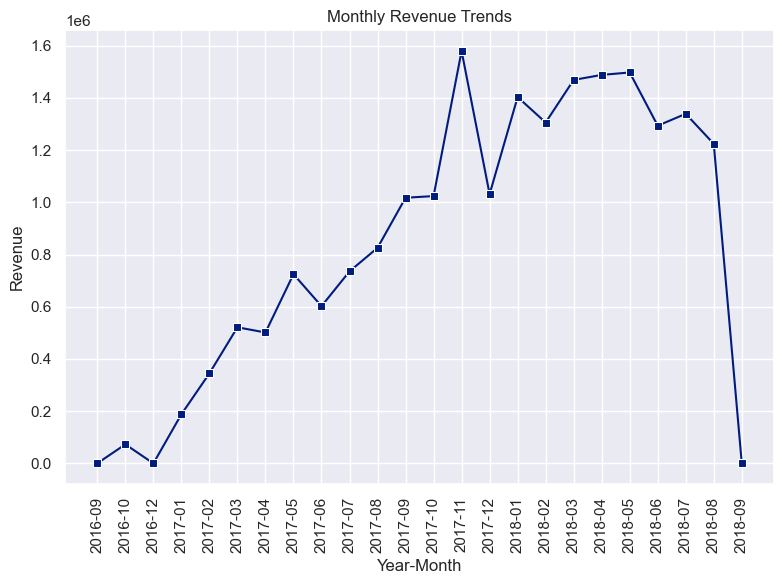

In [26]:
plt.figure(figsize=(8,6))
sns.lineplot(x='year_month', y='payment_value', data=revenue, marker='s')
plt.xticks(rotation = 90)
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue Trends')
plt.tight_layout()

## Product Categories by Average Review Score

In [28]:
category_scores = (
    b4.groupby('product_category_name_english')['review_score']
    .agg(['mean', 'count']).reset_index().sort_values('mean')
)

top10 = category_scores.sort_values('mean', ascending=False).head(10)
bottom10 = category_scores.sort_values('mean', ascending=True).head(10)

### Top 10 Product Categories

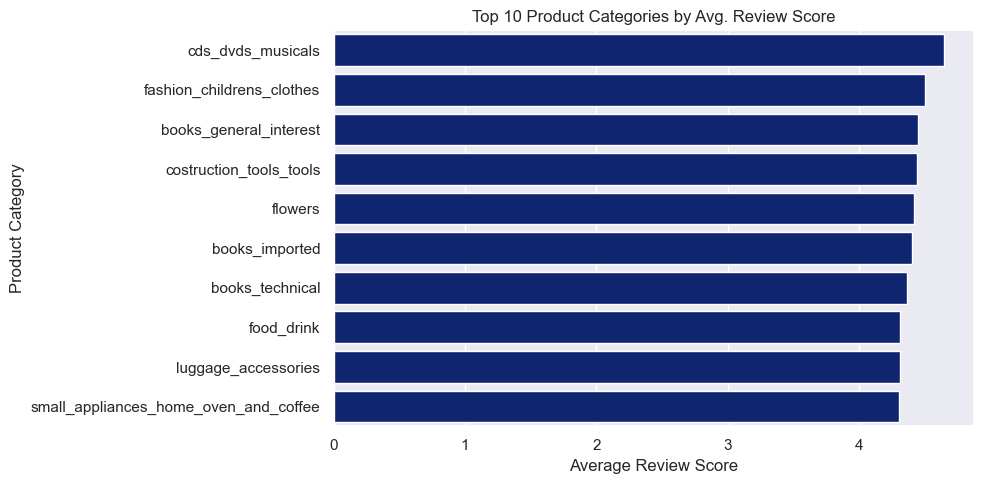

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(x='mean', y='product_category_name_english', data=top10)
plt.title('Top 10 Product Categories by Avg. Review Score')
plt.xlabel('Average Review Score')
plt.ylabel('Product Category')
plt.tight_layout()

### Bottom 10 Product Categories

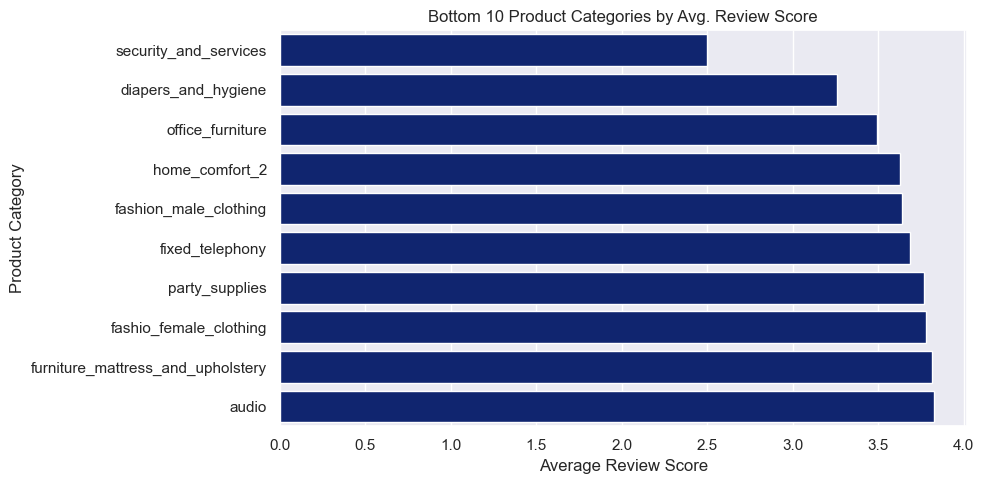

In [30]:
plt.figure(figsize=(10,5))
sns.barplot(x='mean', y='product_category_name_english', data=bottom10)
plt.title('Bottom 10 Product Categories by Avg. Review Score')
plt.xlabel('Average Review Score')
plt.ylabel('Product Category')
plt.tight_layout()

## Regression Between Delivery Time and Review Score

In [31]:
b1['delivery_delay'] = ((b1['order_delivered_customer_date'] - b1['order_estimated_delivery_date']).dt.days)

avg_rating_delay = (
    b1.groupby('delivery_delay')['review_score'].mean().reset_index()
).round(2)

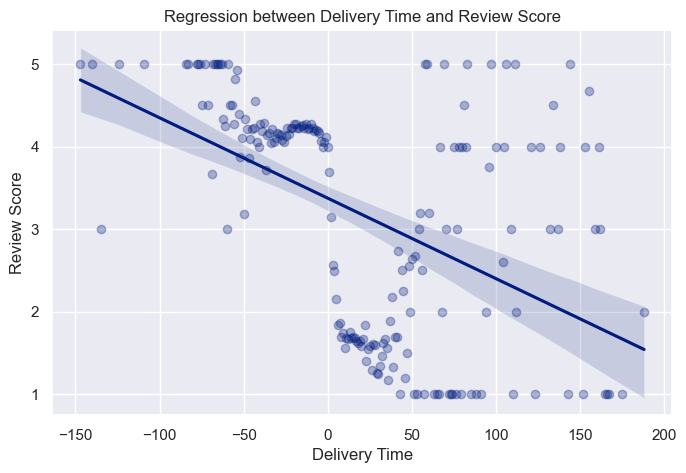

In [32]:
plt.figure(figsize=(8,5))
sns.regplot(x='delivery_delay', y='review_score', data=avg_rating_delay, scatter_kws={'alpha':0.3})
plt.xlabel('Delivery Time')
plt.ylabel('Review Score')
plt.title('Regression between Delivery Time and Review Score')
plt.show()

## Correlation Between Product Weight and Freight Cost

In [33]:
corr = b2['freight_value'].corr(b2['product_weight_g'])
corr.round(2)

0.61

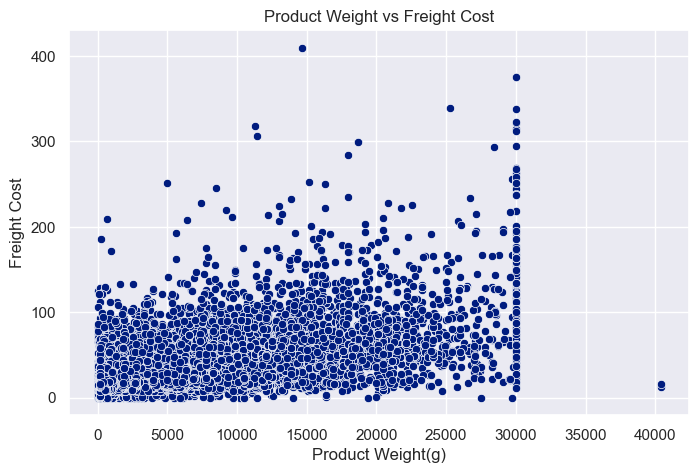

In [50]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="product_weight_g", y="freight_value", data=b2)
plt.title("Product Weight vs Freight Cost")
plt.xlabel("Product Weight(g)")
plt.ylabel("Freight Cost")
plt.show()

## Pie Chart of Overall Delivery Time

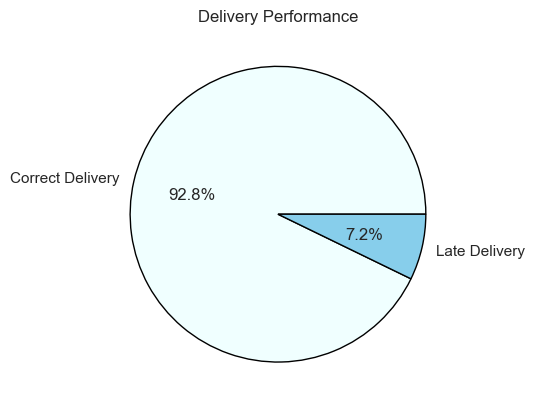

In [62]:
b1['delivery_days'] = (b1['order_delivered_customer_date'] - b1['order_purchase_timestamp']).dt.days
b1['estimated_days'] = (b1['order_estimated_delivery_date'] - b1['order_purchase_timestamp']).dt.days
b1['delay'] = b1['delivery_days'] - b1['estimated_days']

correct_delivery = (b1['delay'] <= 0).sum()
late = (b1['delay'] > 0).sum()

labels = ['Correct Delivery', 'Late Delivery']
colors = ['azure', 'skyblue']

plt.pie([correct_delivery, late], labels=labels, colors=colors,
        autopct='%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title("Delivery Performance")
plt.show()